In [1]:
#importing stuff and defining non important things

import matplotlib.pyplot as plt
import numpy as np

from scipy.constants import hbar, e
from scipy.fft import fft
from functools import lru_cache
from scipy.integrate import quad


#pauli matrices
identity = np.array([[1,0],[0,1]]) 
s1 = np.matrix([[0,1],[1,0]])
s2 = np.matrix([[0,-1j],[1j,0]])
s3 = np.matrix([[1,0],[0,-1]])

hall_conductivity=e**2/(2*np.pi*hbar)

#we use as unit of measure of energy the elettron volt
#hbar=hbar/e
#e=1 #i still use the elettric charge as a variable in case i want to go back to MKS units

Let the two valley indexes be $K_0,K_1$

$-e\mathbf J_{K_{\alpha}}(\mathbf r)= \sum_{\beta\in \{0,1\}} \sigma_{K_\alpha K_\beta}(\mathbf r)\nabla \psi_{K_\beta}(\mathbf r)$

$ \psi_{K_\beta}(\mathbf r)$ is the elettrochemical potential

$ \psi_{K_\beta}(\mathbf r) = V(\mathbf r) - \frac 1e \frac{\partial}{\partial n_{K_\beta}} F(n_{K_0},n_{K_1}, T)$

where  $F(n_{K_0},n_{K_1}, T)$ is the free energy density in term of the local valley density $n_{K_\alpha}(\mathbf r)$, this means that 

$\mu (n_{K_0},n_{K_{1}}, T)=\frac{\partial}{\partial n_{K_\beta}} F(n_{K_0},n_{K_{1}}, T)$

From now on we are going to assume $T=0$, so the electron will have a step distibution

The hamiltonian near the two valleys is

$H_{K_0}=-H_{K_1}^*=\hbar v_f\mathbf k \cdot \mathbf \sigma + \Delta \sigma^z$

where $v_f=\frac {\sqrt 3}2 at/\hbar$ and $a,t$ is the hopping constant and the lattice spacing

for an easier notation we are going to define $q=v_f\hbar k$

The enegy eigenvalues of a Dirac Hamiltonian are 

$E=\pm \sqrt{\Delta^2 + q^2}$

and the Berry curvature is

$\Omega_{K_0,q_xq_y}=\frac 12 \frac{\Delta^2}{q^2E^3}[q_x+q_y-2q]$

if we integrate it between $0$ and $q_f$ we have that

$\int_{q<q_f}\Omega_{K_0,q_xq_y}dq_xdq_y=-2\pi \frac{q_f}{\Delta^2+q_f^2}$

In [2]:
v_f=1e8 #fermi velocity
delta=2*e #this is empirical and should be changed from material to material, we multiply the value for the electron charge to convert joules to eV

# Eigenvalues of the Hamiltonian
def DiracEnergy(k_x,k_y=0): #delta is written in elettron volts
    dispersion_vector=np.array([v_f*hbar*k_x,v_f*hbar*k_y,delta])
    return np.linalg.norm(dispersion_vector)

#Berry curvature of the hamiltonian in terms of k_x and k_y
#this function is wrong
def BerryCurvatureDiracHamiltonian(k_x,k_y=0,delta=0):
    return np.array([k_x,k_y,delta])/2*DiracEnergy(k_x,k_y,delta)**3

/var/folders/vg/h6knjndn79l9ytz887vfbrcm0000gn/T/ipykernel_40604/1652040077.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dispersion_vector=np.array([v_f*hbar*k_x,v_f*hbar*k_y,delta])


Text(0, 0.5, '$E(k)$ [eV]')

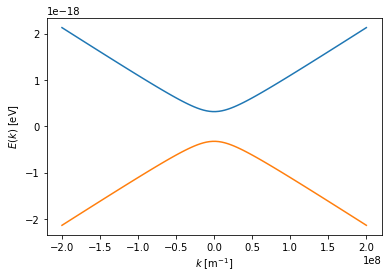

In [3]:
#plot the eigenvalues of the hamiltonian

kx=np.linspace(-2e8,2e8,100)
E1=DiracEnergy(kx)
E2=-DiracEnergy(kx)

plt.plot(kx,E1)
plt.plot(kx,E2)
plt.xlabel('$k$ [m$^{-1}$]')
plt.ylabel('$E(k)$ [eV]')

# No intervalley interactions

For now we are going to ignore intervalley scattering, this means that $\sigma_{K_0K_1}=\sigma_{K_1K_0}=0$, and we will write for simplicity the diagonal elements with just one index ($\sigma_{K_\alpha K_\alpha}=\sigma_{K_\alpha}$)

Keep in mind that each $\sigma_{K_\alpha}$ is a matrix that must be simmetric under rotations this means that the elements are in the form


$\sigma_{K_\alpha}=\begin{vmatrix}
\sigma_{K_\alpha,xx} & \sigma_{K_\alpha,xy}\\
-\sigma^*_{K_\alpha,xy} & \sigma_{K_\alpha,xx}
\end{vmatrix}$

The diagonal entries are from the classic conducibility, while the off diagonal elements are from the Berry curvature

$\sigma_{K_\alpha,xy}=\frac {e^2} \hbar\int f(E_k)\Omega_{K_\alpha}(\mathbf k)\frac{d\mathbf k}{(2\pi)^2}$

from this we can notice that $\sigma_{K_\alpha,xy}\in \R$, and since the two valleys have opposite berry curvature $\sigma_{K_0,xy}=-\sigma_{K_1,xy}$

as far as the diagonal elements, we have that $\sigma_{K_0,xx}=\sigma_{K_1,xx}$

This means that we can define 

$\sigma=\begin{vmatrix}
\sigma_{xx} & \sigma_{xy}\\
-\sigma_{xy} & \sigma_{xx}
\end{vmatrix}=\sigma_{xx}\delta_{ij} + \sigma_{xy}\epsilon_{ij}$

such that $\sigma_{K_0}=\sigma$ and $\sigma_{K_1}=\sigma^T$

If we calculate the $\sigma_{xy}$ we have that

$\sigma_{K_\alpha,xy}=-\frac {e^2}{2\pi \hbar}\frac{\sqrt{\mu^2-\Delta^2}}\mu \Theta(\mu^2-\Delta^2)\textrm{sign}(\mu)$

witch is plotted below

In [4]:
def sigma_xy(mu):
    multiplier=(mu>delta)-1*(mu<-delta)
    if multiplier==0: return hall_conductivity

    f_E=np.sqrt(mu**2-delta**2)/mu
    return hall_conductivity*(1-f_E*multiplier)
sigma_xy=np.vectorize(sigma_xy)

sigma_xx=hall_conductivity*(0.5+1e-2) #this is empirical and should be changed from material to material
def sigma(mu,K=0): #alpha is the valley index
    return sigma_xx*identity-np.array([[0,sigma_xy(mu)],[sigma_xy(mu),0]])*(-1)**K

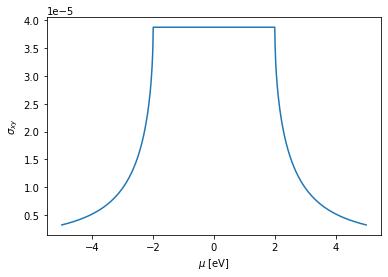

In [5]:
#plotting sigma_xy
mu=np.linspace(-5,5,1000)
s=sigma_xy(mu*e)
plt.plot(mu,s)
plt.xlabel('$\mu$ [eV]')
plt.ylabel('$\sigma_{xy}$')
plt.show()

Since the two valleys are now non-interacting the free energy can be written as the sum of the two Free energies

where $F(n_{K_0},n_{K_1})=F_0(n_{K_0}(\mathbf r))+F_1(n_{K_1}(\mathbf r))$

this means that we will have two distinct chemical potentials

$\mu_\alpha(n_{K_\alpha}(\mathbf r))=\frac{\partial}{\partial n_{K_\alpha}}F(n_{K_0},n_{K_1})=\frac{\partial}{\partial n_{K_\alpha}}F_\alpha(n_{K_\alpha}(\mathbf r))$

This simplifies the trasport equation in 

$-e\mathbf J_{K_{\alpha}}(\mathbf r)= \sigma_{K_\alpha}(\mathbf r)\nabla \psi_{K_\alpha}(\mathbf r)$

$\nabla \psi_{K_\alpha}(\mathbf r)=\nabla V(\mathbf r) -\frac 1e \frac{\partial}{\partial n_{K_\alpha}}\mu_\alpha(n_{K_\alpha}(\mathbf r))\nabla n_{K_\alpha}$

where $\frac{\partial \mu_{K_\alpha}}{\partial n_{K_\alpha}}=\frac{\pi}{\sqrt{2\pi |n|+\Delta^2}}+\Delta\delta(n)\approx \frac \pi\Delta +\Delta\delta(n) \quad \forall \alpha$ 

In [26]:
c=2*np.pi*(hbar*v_f)**2

def mu_n(n):
    return np.sign(n)*np.sqrt(c*np.abs(n)+delta**2)

def dmu_dn(n):
    return c/np.sqrt(c*np.abs(n)+delta**2)

print(dmu_dn(0))

2.180679300162744e-33


#### $n(\mu)$

$\rho(E)=\frac 1\pi E\theta(E^2-\Delta^2)$

If $\mu>0$ number of particles in a dirac hamiltonian with a fermi dirac distibution is

$n=\int_0^\mu \rho(E)dE=\frac 1\pi \int_0^\mu E\theta(E^2-\Delta^2)dE=\frac 1\pi\theta(\mu^2-\Delta^2)\int_\Delta^\mu EdE = \frac {\theta(\mu^2-\Delta^2)}{2\pi}(\mu^2-\Delta^2)$

if $\mu<0$ than we do the same, but with holes, so in the end

$n=\frac {\theta(\mu^2-\Delta^2)}{2\pi}(\mu^2-\Delta^2)\textrm{sign} (\mu)$

In [7]:
def n_mu(mu):
    if mu**2-delta**2<0: return 0

    return np.sign(mu)*(mu**2-delta**2)/c
n_mu=np.vectorize(n_mu)

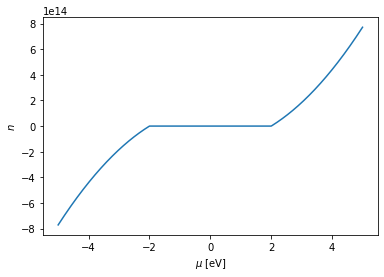

In [8]:
mu=np.linspace(-5,5,1000)
n=n_mu(mu*e)
plt.xlabel('$\mu$ [eV]')
plt.ylabel('$n$')
plt.plot(mu,n)

Putting everything together, and writing explicitely the coordinates with the indices $i,j$

$-eJ_{K_\alpha,i}(\mathbf r)=\sigma_{K_\alpha, ij}E_j(\mathbf r) -\frac 1e \sigma_{K_\alpha, ij}\frac{\partial \mu_\alpha}{\partial n_{K_\alpha}}[n_{K_\alpha}(\mathbf r)]\partial _jn_{K_\alpha}(\mathbf r)$

We can shorten the equation above by defining

$e^2D_{K_\alpha,ij}=\sigma_{K_\alpha, ij}\frac{\partial \mu_\alpha}{\partial n_{K_\alpha}}[n_{K_\alpha}(\mathbf r)]$

$-eJ_{K_\alpha,i}(\mathbf r)=\sigma_{K_\alpha, ij}E_j(\mathbf r) -eD_{K_\alpha,ij}\partial _jn_{K_\alpha}(\mathbf r)$

or, in matrix form

$-e\mathbf J_{K_\alpha}(\mathbf r)=\sigma_{K_\alpha}\mathbf E(\mathbf r) -eD_{K_\alpha}\nabla n_{K_\alpha}(\mathbf r)$

where 

$\sigma_{K_\alpha}$ and  $-eD_{K_\alpha}$ are matrices

In [9]:

def D_K(mu=0,K=0):
    return sigma(mu,K)*dmu_dn(n_mu(mu))/e**2

def J_K(E,grad_n,mu=0,K=0):
    """
    args:
        E(np.array): electric field, must be 2-dimentional
        grad_n(np.array): gradient of the density of charge in the valley k, must be 2-dimentional
    """
    sigma=sigma(mu,K)
    D_K=D_K(mu,K)
    return np.dot(sigma,E)+e*np.dot(D_K,grad_n)

## Re-writing the equations in terms of charge current and valley current

Now we will write the currents in terms fo the charge current $\mathbf J_{c}=\mathbf J_{K_0}+\mathbf J_{K_1}$ and spin current $\mathbf J_{s}=\mathbf J_{K_0}-\mathbf J_{K_1}$

now we define $\sigma_c=\sigma_{K_0}+\sigma_{K_1}$ and $\sigma_s=\sigma_{K_0}-\sigma_{K_1}$, this means that

$\sigma_c=2\sigma_{xx}\delta_{ij}$ and $\sigma_v=2\sigma_{xy}\epsilon_{ij}$

The term $-eD_{K_\alpha}\nabla n_{K_\alpha}(\mathbf r)$ is a little harder to traslate. First off we are going to impose the local charge conservation

$n_c(\mathbf r)=n_{K_0}+n_{K_1}\approx 0$, and so 

$n_v(\mathbf r)=n_{K_0}-n_{K_1}=2n_{K_0}=-2n_{K_1}$

In [10]:
sigma_c=2*sigma_xx

def sigma_v(mu): return 2*sigma_xy(mu)

### Writing $J_c$

Now let's do the sum of the $D_{K_\alpha}\nabla n_{K_\alpha}(\mathbf r)$ terms to write them in terms of charge and valleys degrees of freedom

$D_{K_0}\nabla n_{K_0}+D_{K_1}\nabla n_{K_1}=(D_{K_0}-D_{K_1})\nabla n_v(\mathbf r)/2$

$D_{K_0}-D_{K_1}=\sigma \frac{\partial \mu_0}{\partial n_{K_0}}- \sigma^T \frac{\partial \mu_1}{\partial n_{K_1}}$

since $\mu_v=2\mu_0=-2\mu_1$ and $n_v=2n_{K_0}=-2n_{K_1}$

$D_{K_0}-D_{K_1}=\frac 1{e^2}(\sigma-\sigma^T)\frac{\partial \mu_v}{\partial n_v}=\frac 2{e^2}\sigma_v\frac{\partial \mu_v}{\partial n_v}$

so i define 

$D_{cv}=\frac 2{e^2}\sigma_v\frac{\partial \mu_v}{\partial n_v}\approx\frac 2{e^2} \frac \pi\Delta\sigma_v$

so we get that

$D_{K_0}\nabla n_{K_0}+D_{K_1}\nabla n_{K_1}=D_{cv}n_v$

Putting it all together we have that

$\mathbf J_c(\mathbf r)=\sigma_c \mathbf E(\mathbf r)+eD_{cv}\nabla n_v(\mathbf r)$

Writing all the indices

$J_{c,i}=\sum_j \sigma_{c,xx}\delta_{ij}E_i+D_{cv,xy}\epsilon_{ij}\partial_j n_v$

so we can rewrite them as

$\mathbf J_{c}= \sigma_{c,xx}\mathbf E_i + D_{cv,xy} \nabla \times n_v$

where $\sigma_{c,xx}$ and $D_{cv,xy}$ are scalars

### Writing $\mathbf J_v$

and now the difference of the $D_{K_\alpha}\nabla n_{K_\alpha}(\mathbf r)$ terms to write them in terms of charge and valleys degrees of freedom

$D_{K_0}\nabla n_{K_0}-D_{K_1}\nabla n_{K_1}=(D_{K_0}+D_{K_1})\nabla n_v(\mathbf r)/2$

and with some calculations that are very similar to the one we use to calculate $\mathbf J_c$ we have that

$D_v=\frac12(D_{K_0}+D_{K_1})=\frac 1{e^2}\sigma_c\frac{\partial \mu_c}{\partial n_c}$

so,

$\mathbf J_v(\mathbf r)=\sigma_v\mathbf E(\mathbf r)+eD_{v}\nabla n_v(\mathbf r)$

which can be re-written as

$\mathbf J_{v,i}(\mathbf r)=\sum_j \sigma_{c,xy} \epsilon_{ij} \mathbf E_j(\mathbf r)+eD_{v,xx}\delta_{ij}\partial_j n_v(\mathbf r)$

where $\sigma_{c,xy}$ and $D_{v,xx}$ are scalars


In [11]:
def J_c(E,grad_n,mu=0):
    return J_K(E,grad_n,mu,0)+J_K(E,-grad_n,-mu,delta,1)
    
def J_v(E,grad_n,mu=0):
    return J_K(E,grad_n,mu,0)-J_K(E,-grad_n,-mu,1)

def D_c(mu):
    return (D_K(mu,K=0) - D_K(-mu,K=1))/2

def D_v(mu):
    return (D_K(mu,K=0) + D_K(-mu,K=1))/2

In [12]:
D_v(0)

array([[1.67844049, 0.        ],
       [0.        , 1.67844049]])

Now lets calculate the laplacians!

$\nabla \cdot \mathbf J_c=\nabla \cdot (\sigma_c \mathbf E)+ e\nabla \cdot (D_{cv}\nabla n_v)$

all the divergence in this equation are equal to zero for a reason or another, this means that $\nabla^2 V(x,y)=0$ inside the material il will be easier to find the field inside given the bondray conditions, instead if we calculate

$\nabla \cdot \mathbf J_v=\nabla \times (\sigma_{c,xy} \mathbf E)+ e\nabla \cdot (D_{v,xx}\nabla n_v)$

Now, lets analythe all the terms one by one

- For the continuity equation we have that $\nabla \cdot \mathbf J_v=\frac \partial {\partial t} n_v$, since intervalley scattering is zero, this should be zero, but  why don't add it back now? so we say that it decays exponentially $\frac \partial {\partial t} n_v=-\frac 1 {\tau_v} n_v$

- $e\nabla \cdot (D_{v,xx}\nabla n_v)$ is really nothing special, inside the material $D_{v,xx}$ is constsant so in the end it is equal to $eD_{v,xx}\nabla^2 n_v$

- $\nabla \times (\sigma_{c,xy} \mathbf E)$ is equal to zero inside the material, but on the edge can be non-zero because $\sigma_{c,xy}$ changes form inside to the outside

In the end we get that

$eD_{v,xx}\nabla^2n_v=-\frac 1{\tau_v}n_v- \nabla \times (\sigma_{c,xy} \mathbf E)$

This means that at the equilibrium $n_v\neq 0$ only if you are were $\nabla\times (\sigma_{c,xy} \mathbf E)\neq 0$, and this is only true along the edge

## Notazione

$\omega^2(k)=k^2+l_v^{-2}\quad$ e $\quad l_v^2=D_{v,xx}\tau_v$

$\tan(\theta _{VH})=\sigma _{v,xy}/\sigma _{c,xx}$

In [21]:
tau_v=1e-15 #it is empirical and should be changed from material to material
def l_v(mu):
    return np.sqrt(D_v(mu)[0,0]*tau_v)

def omega2(k,mu): #this is omega^2 be careful!
    return k**2+l_v(mu)**(-2)

def tan_vh(mu):
    return sigma_v(mu)/sigma_c

print(l_v(0),l_v(3*e))

4.096877457558149e-08 3.345086436576104e-08


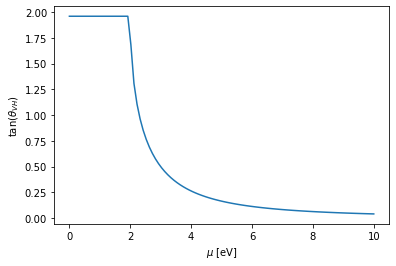

In [22]:
plt.plot(np.linspace(0,10,100),[tan_vh(mu*e) for mu in np.linspace(0,10,100)])
plt.ylabel('$\\tan(\\theta_{VH})$')
plt.xlabel('$\mu$ [eV]')
plt.show()

In [23]:
def R_NLk(k,width=1,mu=0,broadening=False):
    #k=k*1e-17
    if broadening==True:
        broadening=find_klim(width,mu,1e-1)
    else: broadening=1
    k=k*broadening
    omega=np.sqrt(omega2(k,mu))
    tan=tan_vh(mu)
    
    if np.abs(k)==0: return 1#/sigma_xx
    
    nominator=2*omega/(k*width)
    #nominator=2*omega/(k*sigma_xx)
    denominator= omega/np.tanh(k*width/2)+k*tan**2/np.tanh(omega*width/2)

    return nominator/denominator

R_NLk=np.vectorize(R_NLk)

In [24]:
@lru_cache(maxsize=50)
def find_klim(width=1,mu=0,height=1e-2):
    k= np.logspace(-30,20,700,base=10)
    R=np.array([R_NLk(k,width,mu) for k in k])
    return k[np.where(R<height)[0][0]]

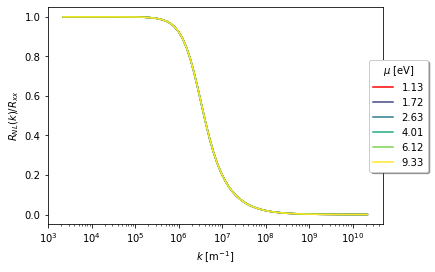

In [25]:
number_of_graphs=6
cmap=plt.get_cmap('viridis')
colors=cmap(np.linspace(1e-2,1,number_of_graphs))

mu=np.logspace(np.log(delta),np.log(10*delta),number_of_graphs,base=2.5)
#mu=np.linspace(delta,2*delta,number_of_graphs)

broadening=False
width=1e-6
for i in range(number_of_graphs):
    k= np.logspace(-5,2,80,base=10)
    if broadening == False: k=k*find_klim(width,mu[i])
    R=[R_NLk(k,width,mu[i],broadening) for k in k]
    plt.plot(k,R,color=colors[i] if i!=0 else 'red',label=str(mu[i])[:4])

#plt.yscale('log')
plt.xscale('log')
plt.xlabel('$k$ [m$^{-1}$]')
plt.ylabel('$R_{NL}(k)/R_{xx}$')
plt.legend(loc='right', bbox_to_anchor=(1.15,0.5), shadow=True,title='$\mu$ [eV]')

In [32]:
@lru_cache(maxsize=50)
def R_NLx(width,mu,limit=8e1,xmax=100):
    x=(np.arange(0,50)*2*int(limit*xmax/50)+1)*np.pi/limit
    RNL=np.array([quad(R_NLk,0,limit,args=(width,mu,True),weight='cos',wvar=i) for i in x])
    broadening=find_klim(width,mu,1e-1)
    return x*broadening,RNL#*brodening #sto termine perchè non c'è?

In [33]:
print(l_v(0))
import texpy as mz
print(find_klim(1e-3,0,1e-1))

4.096877457558149e-08
21615.433436051895


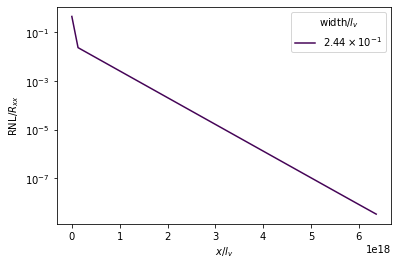

In [36]:
widths=[1e-5,1e-3,1,1e3,1e5,1e7]
widths=[1e-8]
for i,w in enumerate(widths):
    x,RNL=R_NLx(w,0)
    plt.plot(x/l_v(mu=0),np.abs(RNL[:,0]),color=colors[i],label=mz.ns(w/l_v(0)))
    #y=deltaR_NLx(x,0)
    #plt.plot(x/l_v(mu=0),y)
plt.yscale('log')
#plt.xscale('log')
plt.ylabel('RNL/$R_{xx}$')
plt.xlabel('$x/l_v$')
plt.legend(title="width/$l_v$")



In [ ]:
def R_NLx0(x,width=1e-7):
    return -2/(np.pi*width)*np.log(np.abs(np.tanh(np.pi*x/(2*width))))
R_NLx0=np.vectorize(R_NLx0)

def deltaR_NLx(x,mu=0):
    tan=tan_vh(mu)
    L_v=l_v(mu)*np.sqrt(1+tan**2)

    nominator=np.exp(-np.abs(x)/L_v)
    denominator=2*L_v*(1+tan**(-2))

    return nominator/denominator

deltaR_NLx=np.vectorize(deltaR_NLx)

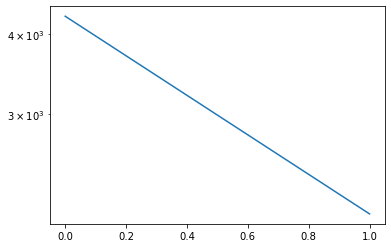

In [ ]:
x=np.linspace(1e-9,l_v(0)*1e0,100)
y=deltaR_NLx(x,0)
plt.plot(x/l_v(0),y)
plt.yscale('log')